# Conformal Prediction: A High-Level Overview

Conformal prediction is a framework for constructing prediction intervals with finite-sample coverage guarantees.
Given a desired miscoverage level $ \alpha \in (0,1) $, conformal methods produce prediction sets that satisfy

$$
\mathbb{P}\left( Y_{n+1} \in \widehat{C}_\alpha(X_{n+1}) \right) \ge 1 - \alpha
$$

under the sole assumption that the data are **exchangeable** (e.g., i.i.d.).

Key ideas:
- Start with *any* regression model (neural network, tree ensemble, etc.)
- Measure how wrong the model is on a calibration set
- Inflate or adjust predictions using these errors to achieve valid coverage

Importantly, conformal prediction is **model-agnostic** and **distribution-free**.


## Dataset

We consider a one-dimensional regression dataset with **heteroscedastic noise**.


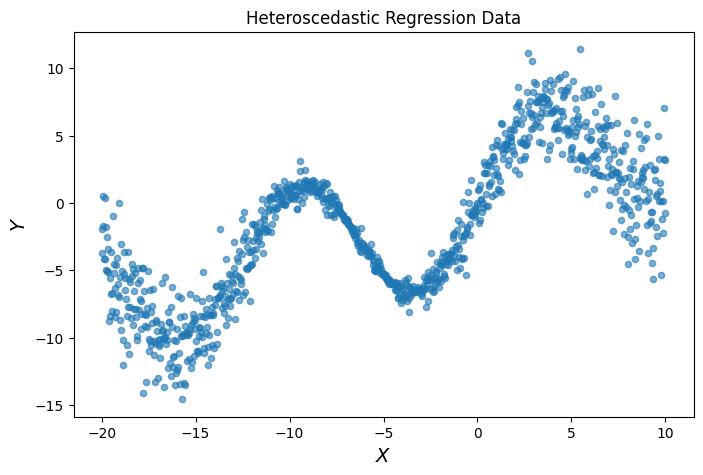

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

# Load dataset
df = pd.read_csv("../data/heteroscedastic_data.csv")

# Extract variables
X = df["x"].values
y = df["y"].values

n = len(df)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=20, alpha=0.6)
plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.title("Heteroscedastic Regression Data")
plt.show()


## Data Splitting Strategy

Conformal prediction requires a **calibration set** that is not used for training.

We split the data as follows:
- 60% training data: fit the regression model
- 20% calibration data: estimate conformity scores
- 20% test data: evaluate empirical coverage

The split is performed randomly to preserve exchangeability.


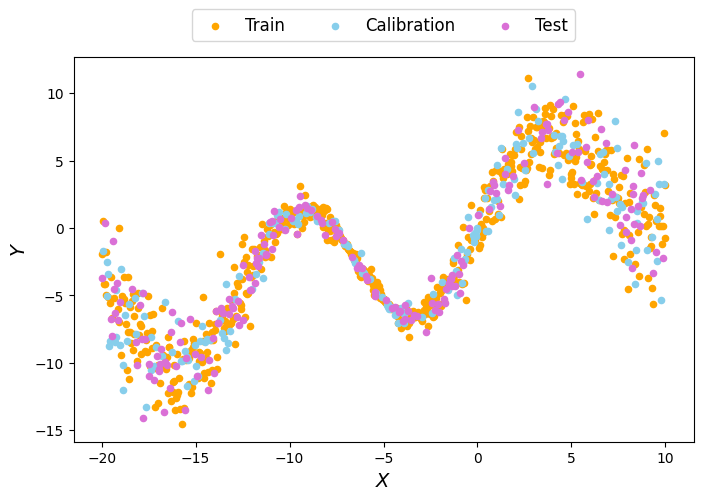

In [203]:
# Random permutation of indices
rng = np.random.default_rng(42)
idx = rng.permutation(n)

# Split proportions
train_end = int(0.6 * n)
cal_end = int(0.8 * n)

train_idx = idx[:train_end]
cal_idx = idx[train_end:cal_end]
test_idx = idx[cal_end:]

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(X[train_idx], y[train_idx], color="orange", label="Train", s=20)
ax.scatter(X[cal_idx], y[cal_idx], color="skyblue", label="Calibration", s=20)
ax.scatter(X[test_idx], y[test_idx], color="orchid", label="Test", s=20)

ax.set_xlabel(r"$X$", fontsize=14)
ax.set_ylabel(r"$Y$", fontsize=14)

ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=3,
    frameon=True,
    fontsize=12,
)

plt.show()



## Base Regression Model and Model-Agnosticism

A key strength of conformal prediction is that it is **model-agnostic**.

This means:
- Conformal prediction does **not** assume any specific form for the regression model
- The base model can be linear, tree-based, kernel-based, or a neural network
- Coverage guarantees depend only on the calibration procedure, not on model correctness

The regression model is used solely to produce point predictions (or preliminary intervals).
Conformal prediction then **post-processes** these predictions using calibration data
to obtain valid prediction intervals.

In this example, we use a simple feedforward neural network as the base regressor.


In [204]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Build a simple feedforward neural network for regression
regr = Sequential()
regr.add(Input(shape=(1,)))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(30, activation="relu"))
regr.add(Dense(1))

# Compile the model
regr.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

The model is trained **only on the training split**.
Neither the calibration set nor the test set is used at this stage.


In [205]:
# Train the model on the training set
regr.fit(
    X[train_idx],
    y[train_idx],
    epochs=1000,
    batch_size=64,
    verbose=0,
)


## Inspecting the Base Model Fit (Training Data Only)

Before introducing conformal calibration, it is useful to visually inspect
the regression model fitted on the training data.

This step serves two purposes:
- Verify that the neural network captures the overall trend in the data
- Emphasize that conformal prediction does **not** require a perfect model

Even a misspecified or imperfect predictor can be conformalized
to produce valid prediction intervals.

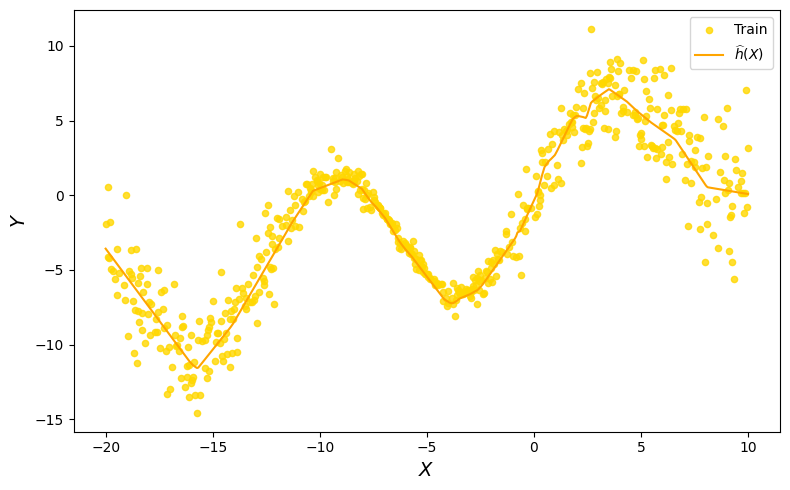

In [206]:
# Create a dense grid over the input space for visualization
X_span = np.linspace(X.min(), X.max(), 500)

# Keras inference (no gradients needed by default)
y_span = regr.predict(X_span.reshape(-1, 1), verbose=0).flatten()

# ---- Plot: training data + fitted function ----
plt.figure(figsize=(8, 5))

plt.scatter(
    X[train_idx],
    y[train_idx],
    color="gold",
    label="Train",
    s=20,
    alpha=0.8,
)

plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


The fitted function $ \widehat{h}(x) $ represents a point predictor learned
solely from the training data.

At this stage:
- No uncertainty information is available
- No coverage guarantees are provided
- Errors may vary significantly across the input space

In the next step, we will use the calibration set to quantify these errors
and transform this point predictor into a valid prediction interval
via conformal prediction.

## Conformal Calibration and Conformity Scores

Conformal prediction converts a point predictor into a prediction interval
by measuring how inaccurate the predictor is on a **calibration set**.

This is done through **conformity scores**, which quantify the disagreement
between predictions and observed responses.

In this example, we use the simplest and most common choice:
**absolute residuals**

$$
s_i = \left| y_i - \widehat{h}(x_i) \right|, \quad i \in \text{calibration set}
$$

These scores will later be aggregated to determine how much we need to
expand predictions to achieve valid coverage.


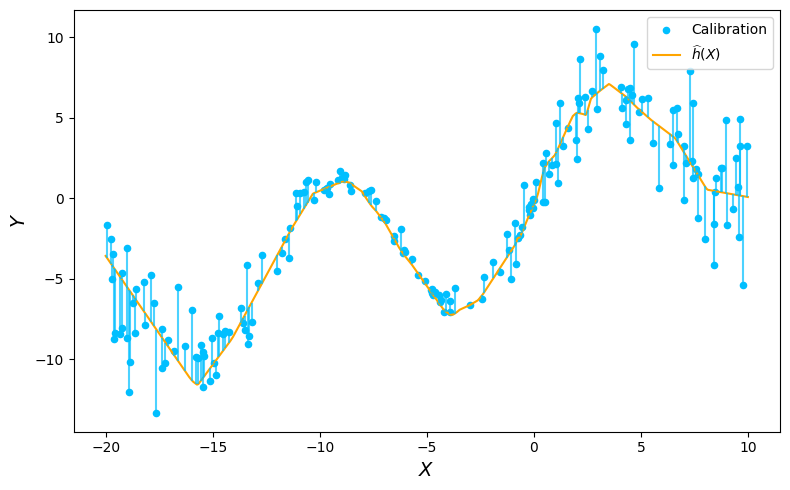

In [207]:
# Predict on the calibration set
y_cal_pred = regr.predict(X[cal_idx].reshape(-1, 1), verbose=0).flatten()

# Compute absolute residuals (conformity scores)
cal_scores = np.abs(y[cal_idx] - y_cal_pred)

# ---- Visualization ----
plt.figure(figsize=(8, 5))

# Calibration points
plt.scatter(
    X[cal_idx],
    y[cal_idx],
    color="deepskyblue",
    label="Calibration",
    s=20,
)

# Fitted function
plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

# Vertical residual lines
for xi, yi, ypi in zip(X[cal_idx], y[cal_idx], y_cal_pred):
    plt.vlines(
        xi,
        ymin=min(yi, ypi),
        ymax=max(yi, ypi),
        color="deepskyblue",
        alpha=0.7,
        lw=1.5,
    )

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Each vertical segment represents a conformity score:
the distance between the prediction and the observed value
on the calibration set.

These scores summarize how uncertain the model is **empirically**,
without making any distributional assumptions.

In the next step, we will:
- Aggregate these scores via an empirical quantile
- Construct prediction intervals with guaranteed coverage

## Selecting the Miscoverage Level and Conformal Quantile

We now choose a target miscoverage level $ \alpha \in (0,1) $.
The goal is to construct prediction intervals that cover the true response
with probability at least $ 1 - \alpha $.

Using the calibration conformity scores $ s_1, \dots, s_{n_{\text{cal}}} $,
split conformal regression defines the conformal radius as

$$
\widehat{q}_{1-\alpha}
= \text{Quantile}_{1-\alpha}
\left( s_1, \dots, s_{n_{\text{cal}}} \right),
$$

with a finite-sample correction that guarantees coverage.



In [208]:
# Miscoverage level
alpha = 0.1

# Number of calibration points
n_cal = len(cal_scores)

# Finite-sample corrected conformal quantile
q = np.quantile(
    cal_scores,
    np.ceil((n_cal + 1) * (1 - alpha)) / n_cal,
)

print(f"Conformal quantile q_(1-alpha): {q:.3f}")


Conformal quantile q_(1-alpha): 3.187


The histogram below shows the empirical distribution of conformity scores.
The dashed line indicates the selected conformal quantile,
which determines the width of the prediction interval.


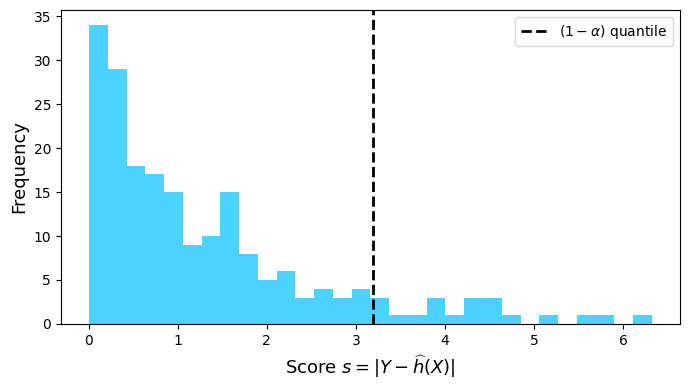

In [209]:
fig, ax = plt.subplots(figsize=(7, 4))

counts, bins, patches = ax.hist(
    cal_scores,
    bins=30,
    color="deepskyblue",
    alpha=0.7,
)

ax.axvline(
    q,
    color="black",
    linestyle="--",
    lw=2,
    label=rf"$(1-\alpha)$ quantile",
)

ax.set_xlabel(r"Score $s = |Y - \widehat{h}(X)|$", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()


## Constructing Prediction Intervals on the Test Set

Given a test input $x$, the split conformal prediction interval is
$$
\widehat{C}_\alpha(x)
=
[
\widehat{h}(x) - \widehat{q}_{1-\alpha},
\;
\widehat{h}(x) + \widehat{q}_{1-\alpha}
],
$$

These intervals are symmetric and inherit a finite-sample coverage guarantee,
regardless of model quality.


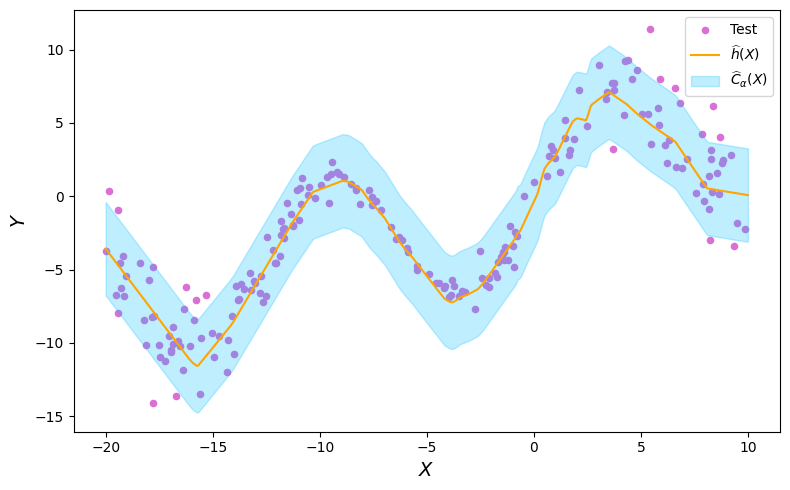

In [210]:
# Predict on test set
y_test_pred = regr.predict(X[test_idx].reshape(-1, 1), verbose=0).flatten()

# Prediction grid already computed: X_span, y_span
lower_span = y_span - q
upper_span = y_span + q

plt.figure(figsize=(8, 5))

plt.scatter(
    X[test_idx],
    y[test_idx],
    color="orchid",
    label="Test",
    s=20,
)

plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

plt.fill_between(
    X_span,
    lower_span,
    upper_span,
    color="deepskyblue",
    alpha=0.25,
    label=r"$\widehat{C}_\alpha(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()

plt.show()


Finally, we verify empirical coverage on the test set.
Although the conformal guarantee holds marginally over new samples,
this provides a useful sanity check.


In [211]:
# Compute empirical coverage on the test set
coverage = np.mean(
    (y[test_idx] >= y_test_pred - q)
    & (y[test_idx] <= y_test_pred + q)
)

print(f"Target coverage: {1 - alpha:.2f}")
print(f"Empirical test coverage: {coverage:.3f}")

Target coverage: 0.90
Empirical test coverage: 0.915


The prediction intervals achieve the target coverage level
*without* assuming any noise distribution or correct model specification.

This is the central promise of conformal prediction:
**valid uncertainty quantification via calibration, not modeling assumptions**.

## Adaptive Conformal Prediction via Learned Residuals

So far, we constructed conformal prediction intervals of the form

$$
\widehat{C}_\alpha(x)
=
\left[
\widehat{h}(x) - \widehat{q}_{1-\alpha},
\;
\widehat{h}(x) + \widehat{q}_{1-\alpha}
\right],
$$

where the radius $ \widehat{q}_{1-\alpha} $ is **constant across inputs**.

However, in heteroscedastic settings, uncertainty varies with \(x\).
Using a single global radius can therefore be overly conservative
in low-noise regions and insufficiently adaptive in high-noise regions.

To address this, we introduce a second model:
- $ \widehat{h}(x) $: predicts the conditional mean
- $ \widehat{u}(x) $: predicts the **scale of the residual**

This leads to *locally adaptive* conformal prediction intervals.


## Learning the Residual Scale

We train the residual model $ \widehat{u}(x) $ on the **training set** only.

The targets are the absolute residuals of the base predictor:

$$
r_i = \left| y_i - \widehat{h}(x_i) \right|,
\quad i \in \text{training set}.
$$

The model $ \widehat{u}(x) $ learns how the magnitude of prediction errors
depends on the input $x$.



In [212]:
# Predictions on training data
y_train_pred = regr.predict(
    X[train_idx].reshape(-1, 1),
    verbose=0
).flatten()

# Absolute residuals on training set
train_residuals = np.abs(y[train_idx] - y_train_pred)


Before fitting the residual model, we visualize the residual structure.
Vertical segments illustrate the magnitude of the prediction error
at each training point.


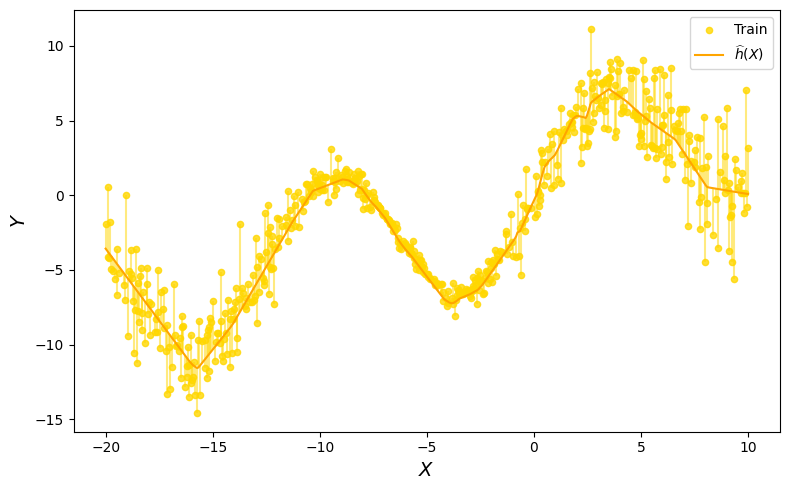

In [213]:
plt.figure(figsize=(8, 5))

plt.scatter(
    X[train_idx],
    y[train_idx],
    color="gold",
    label="Train",
    s=20,
    alpha=0.8,
)

# Vertical residual lines
for xi, yi, ypi in zip(X[train_idx], y[train_idx], y_train_pred):
    plt.vlines(
        xi,
        ymin=min(yi, ypi),
        ymax=max(yi, ypi),
        color="gold",
        alpha=0.5,
        lw=1.5,
    )

plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


## Residual Model $ \widehat{u}(x) $

We now train a second neural network to predict the magnitude of residuals.
This model:
- Takes the same input $x$
- Outputs a **nonnegative scalar**
- Is trained using standard regression loss

No probabilistic assumptions are required. There is also nothing special about neural networks here, the $ \widehat{u}(x) $ model cna be any regressor.


In [214]:
# Residual model
res_model = Sequential()
res_model.add(Input(shape=(1,)))
res_model.add(Dense(30, activation="relu"))
res_model.add(Dense(30, activation="relu"))
res_model.add(Dense(1))

res_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)

# Train residual model
res_model.fit(
    X[train_idx],
    train_residuals,
    epochs=1000,
    batch_size=64,
    verbose=0,
)


## Visualizing the Learned Residual Scale

We now inspect the behavior of the residual model $ \widehat{u}(x) $.

The scatter plot shows the **empirical absolute residuals**
$|y_i - \widehat{h}(x_i)|$ on the training data,
while the curve shows the learned residual scale $ \widehat{u}(x) $.

This visualization helps verify that:
- Residual magnitude depends on the input
- The model captures heteroscedastic structure
- The residual model is learning a smooth envelope of the errors


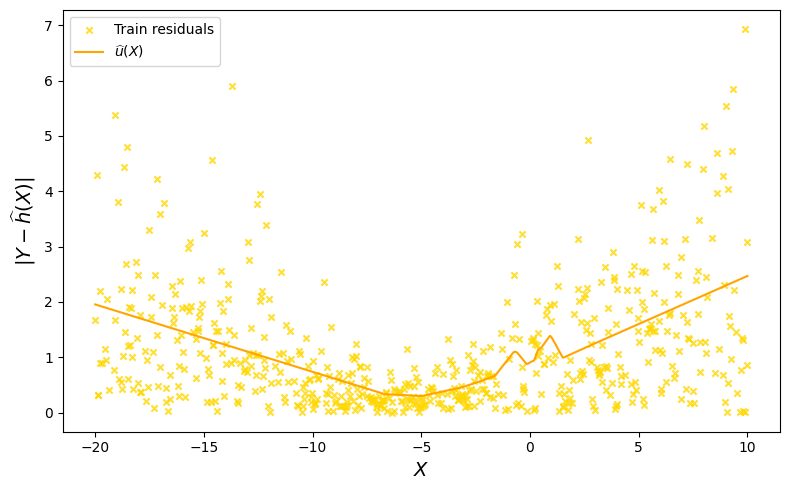

In [215]:
# Predict mean and residual scale on training data
y_train_pred = regr.predict(
    X[train_idx].reshape(-1, 1),
    verbose=0
).flatten()

u_train_pred = res_model.predict(
    X[train_idx].reshape(-1, 1),
    verbose=0
).flatten()

# Predict residual scale on a dense grid
u_span = res_model.predict(
    X_span.reshape(-1, 1),
    verbose=0
).flatten()

# ---- Plot ----
plt.figure(figsize=(8, 5))

# Empirical absolute residuals
plt.scatter(
    X[train_idx],
    np.abs(y_train_pred - y[train_idx]),
    color="gold",
    s=20,
    alpha=0.8,
    marker="x",
    label="Train residuals",
)

# Learned residual function
plt.plot(
    X_span,
    u_span,
    color="orange",
    label=r"$\widehat{u}(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$|Y - \widehat{h}(X)|$", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


## Normalized Conformity Scores

With an input-dependent residual model $ \widehat{u}(x) $, we now define
**normalized conformity scores**.

For each calibration point $ (x_i, y_i) $, the score is

$$
s_i
=
\frac{|y_i - \widehat{h}(x_i)|}{\widehat{u}(x_i)}.
$$

Interpretation:
- The numerator measures prediction error
- The denominator rescales this error by the local uncertainty level

As a result, these scores are approximately **scale-free** across the input space.
This allows conformal prediction to adapt interval widths to heteroscedasticity
while preserving finite-sample coverage.


In [216]:
# Predict mean and residual scale on calibration data
y_cal_pred = regr.predict(
    X[cal_idx].reshape(-1, 1),
    verbose=0
).flatten()

u_cal_pred = res_model.predict(
    X[cal_idx].reshape(-1, 1),
    verbose=0
).flatten()

# Numerical safety (avoid division by zero)
eps = 1e-8
u_cal_pred = np.maximum(u_cal_pred, eps)

# Normalized conformity scores
s = np.abs(y[cal_idx] - y_cal_pred) / u_cal_pred


We visualize the normalized conformity scores over the calibration inputs.
A key diagnostic is whether the scores appear roughly homogeneous across $x$,
indicating successful normalization.


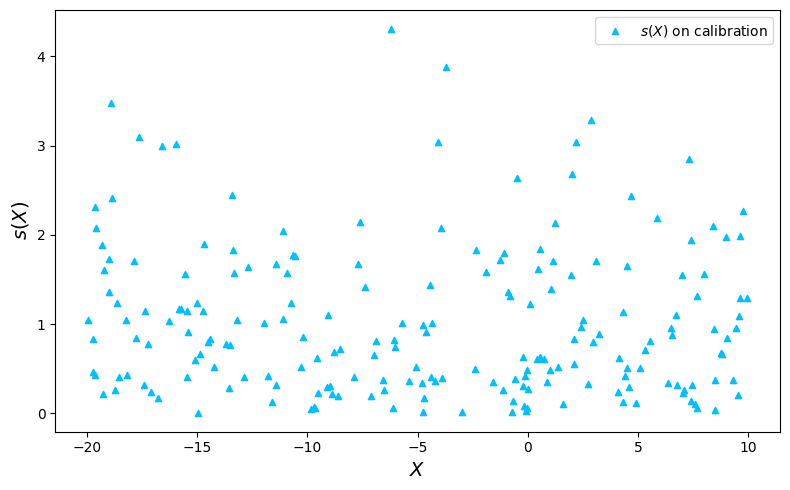

In [217]:
plt.figure(figsize=(8, 5))

plt.scatter(
    X[cal_idx],
    s,
    color="deepskyblue",
    label=r"$s(X)$ on calibration",
    s=20,
    marker="^",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$s(X)$", fontsize=14)
plt.legend()
plt.tight_layout()

plt.show()


If the residual model $ \widehat{u}(x) $ captures heteroscedasticity well,
the normalized scores should:
- Exhibit reduced dependence on $x$
- Concentrate around a common scale

This makes it possible to use a **single conformal quantile**
to construct prediction intervals that are locally adaptive.

## Selecting the Conformal Quantile

Using the normalized conformity scores $ s_1, \dots, s_{n_{\text{cal}}} $,
we select the conformal quantile corresponding to the same miscoverage level
$ \alpha $.

The finite-sample corrected quantile ensures

$$
\mathbb{P}\!\left(
\frac{|Y - \widehat{h}(X)|}{\widehat{u}(X)} \le \widehat{q}_{1-\alpha}
\right)
\ge 1 - \alpha.
$$

This single scalar $ \widehat{q}_{1-\alpha} $ controls the width of
**locally adaptive prediction intervals**.



In [218]:
# Miscoverage level
alpha = 0.1

# Number of calibration points
n_cal = len(s)

# Finite-sample corrected conformal quantile
q = np.quantile(
    s,
    np.ceil((n_cal + 1) * (1 - alpha)) / n_cal,
)

print(f"Adaptive conformal quantile q_(1-alpha): {q:.3f}")


Adaptive conformal quantile q_(1-alpha): 2.135


The histogram below shows the distribution of normalized conformity scores.
The dashed line indicates the selected conformal quantile.


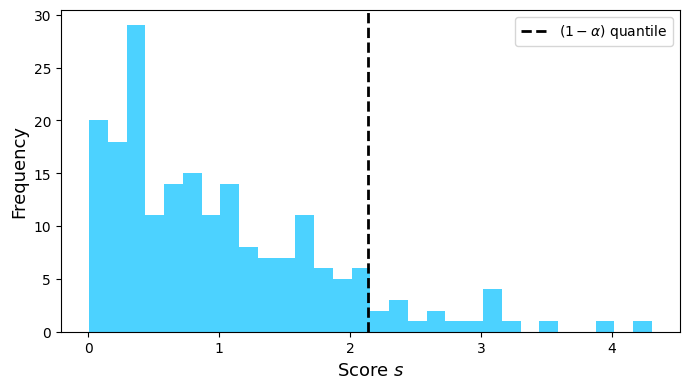

In [219]:
fig, ax = plt.subplots(figsize=(7, 4))

counts, bins, patches = ax.hist(
    s,
    bins=30,
    color="deepskyblue",
    alpha=0.7,
)

ax.axvline(
    q,
    color="black",
    linestyle="--",
    lw=2,
    label=rf"$(1-\alpha)$ quantile",
)

ax.set_xlabel(r"Score $s$", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)
ax.legend()

plt.tight_layout()
plt.show()


## Adaptive Prediction Intervals on the Test Set

For a new input $x$, the adaptive conformal prediction interval is

$$
\widehat{C}_\alpha(x)
=
\left[
\widehat{h}(x)
\; \pm \;
\widehat{q}_{1-\alpha} \, \widehat{u}(x)
\right].
$$

Unlike global conformal intervals, the width now varies with $x$,
expanding in high-noise regions and shrinking where predictions are more reliable.


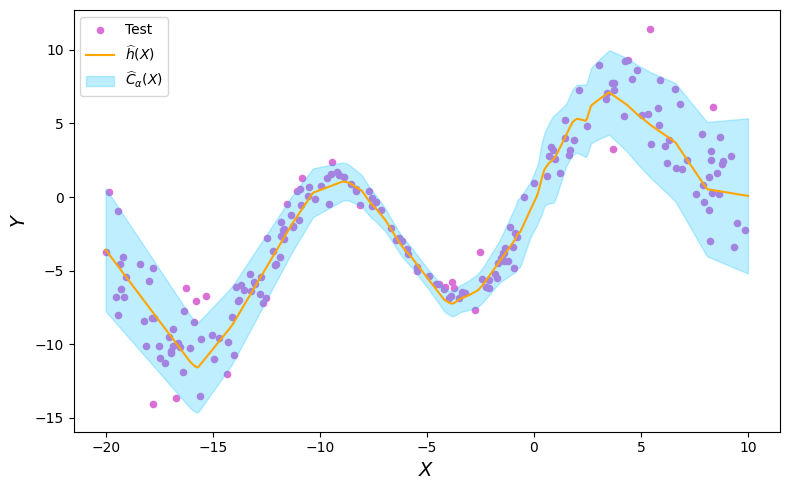

In [220]:
# Predict on test set
y_test_pred = regr.predict(
    X[test_idx].reshape(-1, 1),
    verbose=0
).flatten()

u_test_pred = res_model.predict(
    X[test_idx].reshape(-1, 1),
    verbose=0
).flatten()

# Prediction grid
u_span = res_model.predict(
    X_span.reshape(-1, 1),
    verbose=0
).flatten()

lower_span = y_span - q * u_span
upper_span = y_span + q * u_span

plt.figure(figsize=(8, 5))

plt.scatter(
    X[test_idx],
    y[test_idx],
    color="orchid",
    label="Test",
    s=20,
)

plt.plot(
    X_span,
    y_span,
    color="orange",
    label=r"$\widehat{h}(X)$",
)

plt.fill_between(
    X_span,
    lower_span,
    upper_span,
    color="deepskyblue",
    alpha=0.25,
    label=r"$\widehat{C}_\alpha(X)$",
)

plt.xlabel(r"$X$", fontsize=14)
plt.ylabel(r"$Y$", fontsize=14)
plt.legend()
plt.tight_layout()

plt.show()


## Empirical Coverage

We now evaluate empirical coverage on the test set.

For each test point $x_i$, the adaptive conformal prediction interval is

$$
\widehat{C}_\alpha(x_i)
=
\left[
\widehat{h}(x_i) - \widehat{q}_{1-\alpha}\widehat{u}(x_i),
\;
\widehat{h}(x_i) + \widehat{q}_{1-\alpha}\widehat{u}(x_i)
\right].
$$

Empirical coverage is the fraction of test responses that fall inside
their corresponding prediction intervals.


In [221]:
# Lower and upper bounds on the test set
lower_test = y_test_pred - q * u_test_pred
upper_test = y_test_pred + q * u_test_pred

# Empirical coverage
empirical_coverage = np.mean(
    (y[test_idx] >= lower_test) &
    (y[test_idx] <= upper_test)
)

print(f"Target coverage: {1 - alpha:.2f}")
print(f"Empirical test coverage: {empirical_coverage:.3f}")


Target coverage: 0.90
Empirical test coverage: 0.915


The empirical coverage should be close to the target level $1-\alpha$.

Small deviations are expected due to finite-sample variability,
but systematic undercoverage would indicate a failure in either:
- the residual model $ \widehat{u}(x) $, or
- the calibration procedure.

Importantly, coverage is achieved *without* assuming any noise distribution
and while allowing prediction intervals to adapt to heteroscedasticity.

